<a href="https://colab.research.google.com/github/NeonLabs146/PyTorch_081/blob/main/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 54.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=4e648c8936a08bc22a90d74aefddbcc5e8addcd1742fc4f11c27f4d062f4739d
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=4a6e20dd0410e503a2abf4e5cddeba697768b13800b59c2f3fa88977a4cd60c0
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 28.54 MiB/s, done.
Resolving deltas: 100% (3/3), done.


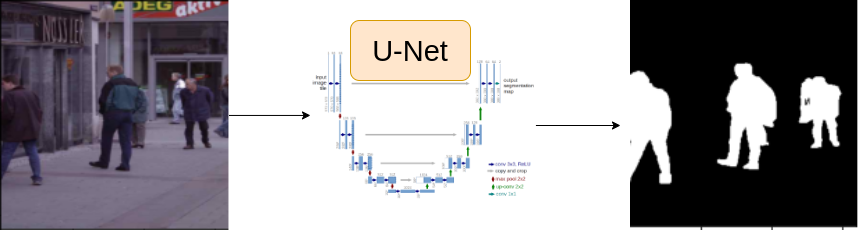

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper  #for visualization

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = "/content/Human-Segmentation-Dataset-master/train.csv"
Data_DIR = "/content/"

In [90]:
Device = "cuda"
epochs = 25
lr = 0.001

image_size = 320
batch_size = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [7]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [8]:
row = df.iloc[2]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

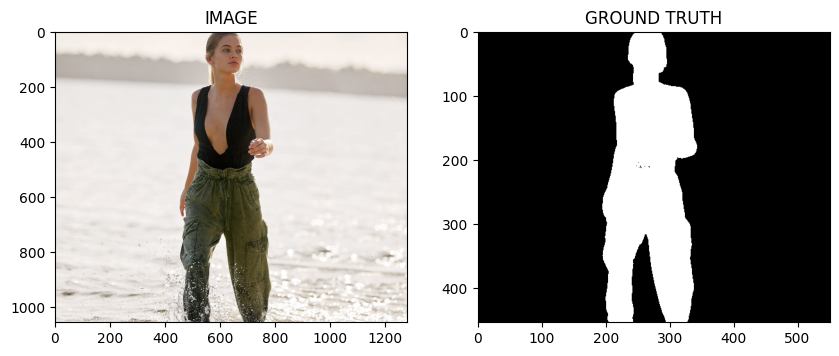

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [10]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [11]:
import albumentations as A

In [12]:
def get_train_augs():
  return A.Compose([
      A.Resize(image_size, image_size),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(image_size, image_size)
  ])

# Task 4 : Create Custom Dataset

In [13]:
from torch.utils.data import Dataset

In [14]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  #(h, w, c)
    mask = np.expand_dims(mask, axis=-1)  #(h, w, 1)

    if self.augmentations:
      # Disable shape check in Albumentations Compose
      self.augmentations = A.Compose(self.augmentations.transforms, is_check_shapes=False)
      data = self.augmentations(image=image, mask=mask)
      image = data["image"]
      mask = data["mask"]

   #(h, w, c) -> (c, h, w)
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [15]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [16]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


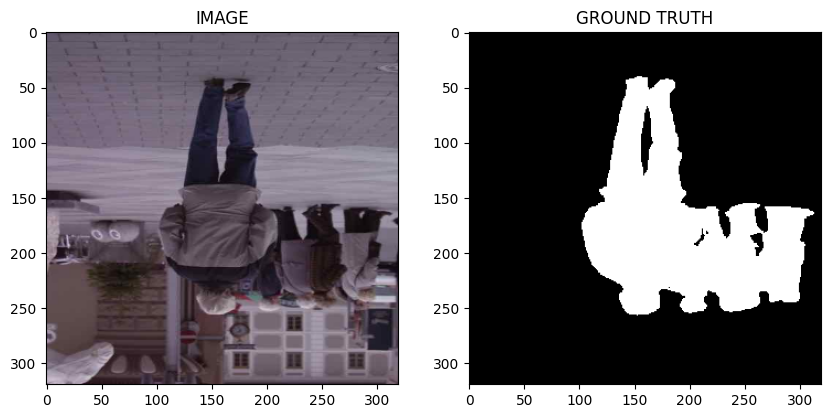

In [17]:
idx = 35
image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [18]:
from torch.utils.data import DataLoader

In [19]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size)

In [20]:
print(f"Total number of batches in trainloader : {len(trainloader)}")
print(f"Total number of batches in validloader : {len(validloader)}")

Total number of batches in trainloader : 15
Total number of batches in validloader : 4


In [21]:
for image, mask in trainloader:
  break

print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")

One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [22]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [85]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )
  def forward(self, images, masks = None):
    logits = self.arc(images)
    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2
    return logits

In [86]:
model = SegmentationModel()
model.to(Device)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [87]:
def train_fn(loader, model, optimizer):
  model.train()

  total_loss =0.0

  for image, mask in tqdm(loader):
    image = image.to(Device)
    mask = mask.to(Device)

    optimizer.zero_grad()
    logits, loss = model(image, mask)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss/len(loader)

In [88]:
def eval_fn(loader, model):
  model.eval()

  total_loss =0.0
  with torch.no_grad():
    for image, mask in tqdm(loader):
      image = image.to(Device)
      mask = mask.to(Device)

      logits, loss = model(image, mask)

      total_loss += loss.item()
  return total_loss/len(loader)

# Task 8 : Train Model

In [91]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [92]:
best_val_loss = np.Inf
for epoch in range(epochs):
  train_loss = train_fn(trainloader, model, optimizer)
  val_loss = eval_fn(validloader, model)
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    print("Saved Best Model!")
    torch.save(model.state_dict(), "Best_model.pt")

  print(f"Epoch : {epoch+1}, Train Loss : {train_loss:.4f}, Val Loss : {val_loss:.4f}")

100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Saved Best Model!
Epoch : 1, Train Loss : 0.9262, Val Loss : 1.0788


100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Saved Best Model!
Epoch : 2, Train Loss : 0.4265, Val Loss : 0.3179


100%|██████████| 4/4 [00:00<00:00,  4.62it/s]


Saved Best Model!
Epoch : 3, Train Loss : 0.2835, Val Loss : 0.2452


100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Saved Best Model!
Epoch : 4, Train Loss : 0.2338, Val Loss : 0.2101


100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


Epoch : 5, Train Loss : 0.1912, Val Loss : 0.2165


100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Saved Best Model!
Epoch : 6, Train Loss : 0.1643, Val Loss : 0.2045


100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


Saved Best Model!
Epoch : 7, Train Loss : 0.1963, Val Loss : 0.1806


100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Saved Best Model!
Epoch : 8, Train Loss : 0.1600, Val Loss : 0.1767


100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch : 9, Train Loss : 0.1385, Val Loss : 0.2094


100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


Epoch : 10, Train Loss : 0.1340, Val Loss : 0.1886


100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Saved Best Model!
Epoch : 11, Train Loss : 0.1151, Val Loss : 0.1567


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


Epoch : 12, Train Loss : 0.1164, Val Loss : 0.1800


100%|██████████| 4/4 [00:00<00:00,  5.59it/s]


Epoch : 13, Train Loss : 0.1266, Val Loss : 0.2153


100%|██████████| 4/4 [00:00<00:00,  5.61it/s]


Epoch : 14, Train Loss : 0.1406, Val Loss : 0.2366


100%|██████████| 4/4 [00:00<00:00,  5.71it/s]


Epoch : 15, Train Loss : 0.1125, Val Loss : 0.1700


100%|██████████| 4/4 [00:00<00:00,  5.68it/s]


Epoch : 16, Train Loss : 0.1019, Val Loss : 0.1840


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


Saved Best Model!
Epoch : 17, Train Loss : 0.0976, Val Loss : 0.1477


100%|██████████| 4/4 [00:00<00:00,  5.65it/s]


Epoch : 18, Train Loss : 0.1018, Val Loss : 0.1644


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


Epoch : 19, Train Loss : 0.1032, Val Loss : 0.1679


100%|██████████| 4/4 [00:00<00:00,  5.72it/s]


Epoch : 20, Train Loss : 0.0998, Val Loss : 0.1503


100%|██████████| 4/4 [00:00<00:00,  5.70it/s]


Epoch : 21, Train Loss : 0.0978, Val Loss : 0.1799


100%|██████████| 4/4 [00:00<00:00,  5.76it/s]


Epoch : 22, Train Loss : 0.0869, Val Loss : 0.1497


100%|██████████| 4/4 [00:00<00:00,  5.76it/s]


Saved Best Model!
Epoch : 23, Train Loss : 0.0745, Val Loss : 0.1447


100%|██████████| 4/4 [00:00<00:00,  5.72it/s]


Saved Best Model!
Epoch : 24, Train Loss : 0.0801, Val Loss : 0.1318


100%|██████████| 4/4 [00:00<00:00,  5.74it/s]

Epoch : 25, Train Loss : 0.0759, Val Loss : 0.1625


# Task 9 : Inference

<ipython-input-94-afd17d1ae3c8>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("Best_model.pt"))


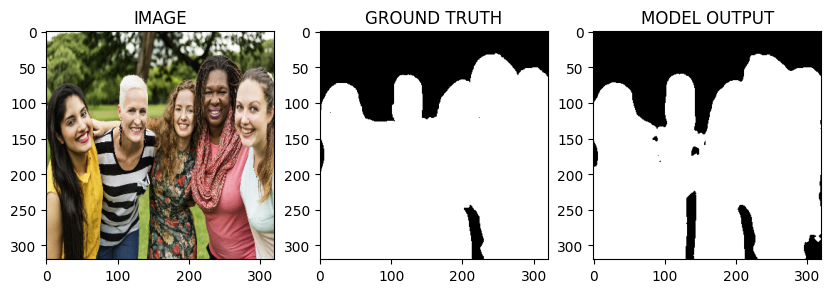

In [94]:
idx = 55

model.load_state_dict(torch.load("Best_model.pt"))
model.eval()

image, mask = validset[idx]
logits_mask = model(image.to(Device).unsqueeze(0))    #(c,h,w)-> (1,c,h,w)

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0
pred_mask = pred_mask.detach().cpu().squeeze(0)
helper.show_image(image, mask, pred_mask)